In [3]:
import pydicom
import os
import cv2
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
INPUT_FOLDER = 'data/stage_2_train_images'  
OUTPUT_FOLDER = 'data/processed_pngs'       
CSV_PATH = 'data/stage_2_train_labels.csv'

In [5]:
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

print(f"Input: {INPUT_FOLDER}")
print(f"Output: {OUTPUT_FOLDER}")

Input: data/stage_2_train_images
Output: data/processed_pngs


In [6]:
def process_dcm(filename):
    """Converts a single DICOM file to a standardized PNG."""
    dcm_path = os.path.join(INPUT_FOLDER, filename)
    
    try:
        # 1. Read DICOM
        dcm = pydicom.dcmread(dcm_path)
        img = dcm.pixel_array
        
        img = cv2.resize(img, (224, 224))
        
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255.0
        img = img.astype(np.uint8)
        
        img = cv2.merge([img, img, img])
        
        png_filename = filename.replace('.dcm', '.png')
        save_path = os.path.join(OUTPUT_FOLDER, png_filename)
        cv2.imwrite(save_path, img)
        return True
        
    except Exception as e:
        return False

Found 26684 DICOM images. Converting to PNG...


  0%|          | 0/26684 [00:00<?, ?it/s]

Successfully converted 26684 images.

Sample Processed Image:


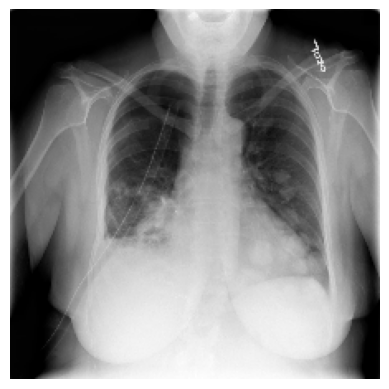

In [7]:
if not os.path.exists(INPUT_FOLDER):
    print(f"ERROR: Could not find folder '{INPUT_FOLDER}'.")
else:
    files = [f for f in os.listdir(INPUT_FOLDER) if f.endswith('.dcm')]
    print(f"Found {len(files)} DICOM images. Converting to PNG...")
    
    count = 0
    for file in tqdm(files):
        if process_dcm(file):
            count += 1
            
    print(f"Successfully converted {count} images.")

    print("\nSample Processed Image:")
    sample_img = cv2.imread(os.path.join(OUTPUT_FOLDER, files[0].replace('.dcm', '.png')))
    plt.imshow(sample_img)
    plt.axis('off')
    plt.show()

In [8]:
df = pd.read_csv(CSV_PATH)

In [9]:
df_clean = df.groupby('patientId')['Target'].max().reset_index()

In [10]:
df_clean['filename'] = df_clean['patientId'] + '.png'

print(f"Total Unique Patients: {len(df_clean)}")
print(f"Positive Pneumonia Cases: {df_clean['Target'].sum()}")

Total Unique Patients: 26684
Positive Pneumonia Cases: 6012


In [11]:
X = df_clean
y = df_clean['Target']

In [12]:
train_df, temp_df = train_test_split(X, test_size=0.2, random_state=42, stratify=y)

In [13]:
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Target'])

In [14]:
train_df.to_csv('data/train_split.csv', index=False)
val_df.to_csv('data/val_split.csv', index=False)
test_df.to_csv('data/test_split.csv', index=False)

In [15]:
print("\n--- Split Complete ---")
print(f"Training Set:   {len(train_df)} images -> saved to 'data/train_split.csv'")
print(f"Validation Set: {len(val_df)} images -> saved to 'data/val_split.csv'")
print(f"Test Set:       {len(test_df)} images -> saved to 'data/test_split.csv'")


--- Split Complete ---
Training Set:   21347 images -> saved to 'data/train_split.csv'
Validation Set: 2668 images -> saved to 'data/val_split.csv'
Test Set:       2669 images -> saved to 'data/test_split.csv'
